<a href="https://colab.research.google.com/github/Deepikadandolu/internproject2/blob/main/rp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [351]:
 #0: IMPORT REQUIRED LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

In [352]:
 #  1: LOAD CSV FILE (CLEAN DATA)

# Load CSV file
df = pd.read_csv(
    "/content/drive/MyDrive/837 - Sheet1.csv",
    header=0
)

# Quick sanity check
df.head(), df.shape


(   Timestamp [ms]  CPU cores  CPU capacity provisioned [MHZ]  CPU usage [MHZ]  \
 0      1376314846          1                      2925.99923              0.0   
 1      1376315146          1                      2925.99923              0.0   
 2      1376315446          1                      2925.99923              0.0   
 3      1376315746          1                      2925.99923              0.0   
 4      1376316046          1                      2925.99923              0.0   
 
    CPU usage [%]  Memory capacity provisioned [KB]  Memory usage [KB]  \
 0            0.0                          704512.0        6290.400000   
 1            0.0                          704512.0           0.000000   
 2            0.0                          704512.0        9086.133333   
 3            0.0                          704512.0        2096.800000   
 4            0.0                          704512.0       20269.866670   
 
    Disk read throughput [KB/s]  Disk write throughput [KB/s

In [353]:
 #2: CLEAN COLUMN NAMES
# Remove stray semicolons and whitespace from column names
df.columns = (
    df.columns
      .astype(str)
      .str.replace(";", "", regex=False)
      .str.strip()
)

df.columns

Index(['Timestamp [ms]', 'CPU cores', 'CPU capacity provisioned [MHZ]',
       'CPU usage [MHZ]', 'CPU usage [%]', 'Memory capacity provisioned [KB]',
       'Memory usage [KB]', 'Disk read throughput [KB/s]',
       'Disk write throughput [KB/s]', 'Network received throughput [KB/s]',
       'Network transmitted throughput [KB/s]'],
      dtype='object')

In [354]:
 #3.PARSE TIMESTAMP & SET INDEX

TIME_COL = "Timestamp [ms]"

# Convert timestamp column to datetime (UNIX seconds)
df[TIME_COL] = pd.to_datetime(df[TIME_COL], unit="s")

# Set as index
df.set_index(TIME_COL, inplace=True)

# Sort by time
df.sort_index(inplace=True)

# Sanity check
df.head(), df.index.min(), df.index.max()

(                     CPU cores  CPU capacity provisioned [MHZ]  \
 Timestamp [ms]                                                   
 2013-08-12 13:40:46          1                      2925.99923   
 2013-08-12 13:45:46          1                      2925.99923   
 2013-08-12 13:50:46          1                      2925.99923   
 2013-08-12 13:55:46          1                      2925.99923   
 2013-08-12 14:00:46          1                      2925.99923   
 
                      CPU usage [MHZ]  CPU usage [%]  \
 Timestamp [ms]                                        
 2013-08-12 13:40:46              0.0            0.0   
 2013-08-12 13:45:46              0.0            0.0   
 2013-08-12 13:50:46              0.0            0.0   
 2013-08-12 13:55:46              0.0            0.0   
 2013-08-12 14:00:46              0.0            0.0   
 
                      Memory capacity provisioned [KB]  Memory usage [KB]  \
 Timestamp [ms]                                           

In [355]:
#4: EXTRACT CPU & MEMORY SERIES
CPU_COL = "CPU usage [%]"
MEM_COL = "Memory usage [KB]"

# Ensure numeric (extra safety)
df[CPU_COL] = pd.to_numeric(df[CPU_COL], errors="coerce")
df[MEM_COL] = pd.to_numeric(df[MEM_COL], errors="coerce")

# Extract series
cpu_series = df[CPU_COL]
mem_series = df[MEM_COL]

# Drop rows where either is missing
cpu_series = cpu_series.dropna()
mem_series = mem_series.dropna()

# Sanity check
cpu_series.head(), mem_series.head(), cpu_series.shape, mem_series.shape


(Timestamp [ms]
 2013-08-12 13:40:46    0.0
 2013-08-12 13:45:46    0.0
 2013-08-12 13:50:46    0.0
 2013-08-12 13:55:46    0.0
 2013-08-12 14:00:46    0.0
 Name: CPU usage [%], dtype: float64,
 Timestamp [ms]
 2013-08-12 13:40:46     6290.400000
 2013-08-12 13:45:46        0.000000
 2013-08-12 13:50:46     9086.133333
 2013-08-12 13:55:46     2096.800000
 2013-08-12 14:00:46    20269.866670
 Name: Memory usage [KB], dtype: float64,
 (8636,),
 (8636,))

In [356]:
# 5: RESAMPLING (10-MIN & 1-HOUR)
# 1. 10-minute resampling
cpu_10min = cpu_series.resample("10min").mean()
mem_10min = mem_series.resample("10min").mean()

# 2. 1-hour resampling
cpu_1h = cpu_series.resample("1H").mean()
mem_1h = mem_series.resample("1H").mean()

# 3. Drop NaNs created by resampling
cpu_10min = cpu_10min.dropna()
mem_10min = mem_10min.dropna()
cpu_1h = cpu_1h.dropna()
mem_1h = mem_1h.dropna()

# 4. Sanity check
print("CPU 10-min:", cpu_10min.shape)
print("MEM 10-min:", mem_10min.shape)
print("CPU 1-hour:", cpu_1h.shape)
print("MEM 1-hour:", mem_1h.shape)

cpu_10min.head(), cpu_1h.head()


CPU 10-min: (4320,)
MEM 10-min: (4320,)
CPU 1-hour: (721,)
MEM 1-hour: (721,)


(Timestamp [ms]
 2013-08-12 13:40:00    0.0
 2013-08-12 13:50:00    0.0
 2013-08-12 14:00:00    0.0
 2013-08-12 14:10:00    0.0
 2013-08-12 14:20:00    0.0
 Freq: 10min, Name: CPU usage [%], dtype: float64,
 Timestamp [ms]
 2013-08-12 13:00:00    0.0
 2013-08-12 14:00:00    0.0
 2013-08-12 15:00:00    0.0
 2013-08-12 16:00:00    0.0
 2013-08-12 17:00:00    0.0
 Freq: h, Name: CPU usage [%], dtype: float64)

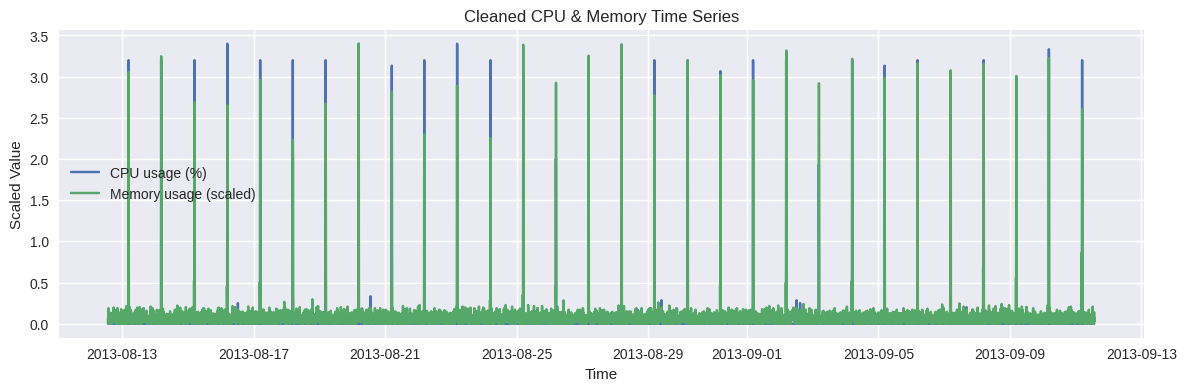

In [357]:
 #6: VISUAL SANITY CHECK

plt.figure(figsize=(14, 4))

# Plot CPU usage (%)
plt.plot(
    df[CPU_COL],
    label="CPU usage (%)"
)

# Safe scaling for memory
cpu_max = df[CPU_COL].max()
if cpu_max == 0:
    mem_scaled = df[MEM_COL] / df[MEM_COL].max()
else:
    mem_scaled = df[MEM_COL] / df[MEM_COL].max() * cpu_max

plt.plot(
    mem_scaled,
    label="Memory usage (scaled)"
)

plt.legend()
plt.title("Cleaned CPU & Memory Time Series")
plt.xlabel("Time")
plt.ylabel("Scaled Value")
plt.show()


In [358]:
 #6A: DATA INTEGRITY CHECK

print("Total rows:", len(df))
print("\nNon-null counts per column:\n")
print(df.notna().sum())

print("\nSample raw rows:")
df.head(10)

Total rows: 8636

Non-null counts per column:

CPU cores                                8636
CPU capacity provisioned [MHZ]           8636
CPU usage [MHZ]                          8636
CPU usage [%]                            8636
Memory capacity provisioned [KB]         8636
Memory usage [KB]                        8636
Disk read throughput [KB/s]              8636
Disk write throughput [KB/s]             8636
Network received throughput [KB/s]       8636
Network transmitted throughput [KB/s]    8636
dtype: int64

Sample raw rows:


,CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s]
Timestamp [ms],,,,,,,,,,
2013-08-12 13:40:46,1,2925.99923,0.0,0.0,704512.0,6290.400000,0,0.0,0,0
2013-08-12 13:45:46,1,2925.99923,0.0,0.0,704512.0,0.000000,0,0.0,0,0
2013-08-12 13:50:46,1,2925.99923,0.0,0.0,704512.0,9086.133333,0,0.0,0,0
2013-08-12 13:55:46,1,2925.99923,0.0,0.0,704512.0,2096.800000,0,0.0,0,0
2013-08-12 14:00:46,1,2925.99923,0.0,0.0,704512.0,20269.866670,0,0.0,0,0
2013-08-12 14:05:46,1,2925.99923,0.0,0.0,704512.0,20968.800000,0,0.0,0,0
2013-08-12 14:10:46,1,2925.99923,0.0,0.0,704512.0,6290.400000,0,0.0,0,0
2013-08-12 14:15:46,1,2925.99923,0.0,0.0,704512.0,2795.733333,0,0.0,0,0
2013-08-12 14:20:46,1,2925.99923,0.0,0.0,704512.0,4193.600000,0,0.2,0,0


In [359]:
cpu_series = df[CPU_COL]
mem_series = df[MEM_COL]

In [360]:
 # CPU aggregation

# 10-minute aggregation (mean)
cpu_10min = cpu_series.resample("10min").mean()

# 1-hour aggregation (mean)
cpu_1h = cpu_series.resample("1h").mean()

print("CPU 10-min shape:", cpu_10min.shape)
print("CPU 1-hour shape:", cpu_1h.shape)

CPU 10-min shape: (4320,)
CPU 1-hour shape: (721,)


In [361]:
# Memory aggregation
# 10-minute aggregation (mean)
mem_10min = mem_series.resample("10min").mean()

# 1-hour aggregation (mean)
mem_1h = mem_series.resample("1h").mean()

print("Memory 10-min shape:", mem_10min.shape)
print("Memory 1-hour shape:", mem_1h.shape)

Memory 10-min shape: (4320,)
Memory 1-hour shape: (721,)


In [362]:
# Clean aggregated series
cpu_10min = cpu_10min.dropna()
cpu_1h    = cpu_1h.dropna()

mem_10min = mem_10min.dropna()
mem_1h    = mem_1h.dropna()


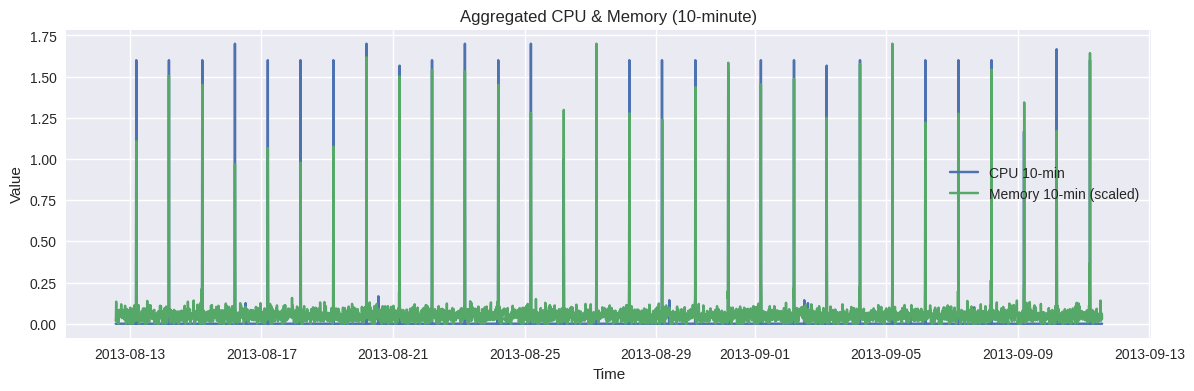

In [363]:
# Plot aggregated CPU & Memory

plt.figure(figsize=(14, 4))

plt.plot(cpu_10min, label="CPU 10-min")
plt.plot(
    mem_10min / mem_10min.max() * cpu_10min.max(),
    label="Memory 10-min (scaled)"
)

plt.title("Aggregated CPU & Memory (10-minute)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

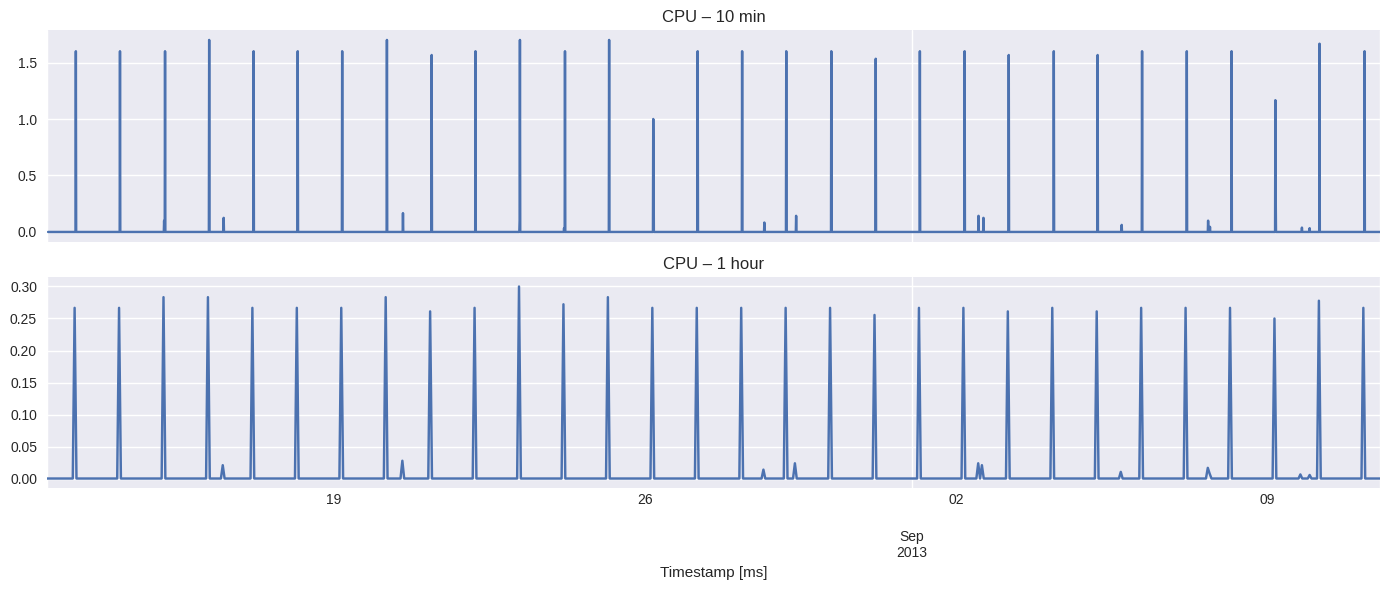

In [364]:
fig, ax = plt.subplots(2, 1, figsize=(14,6), sharex=True)

cpu_10min.plot(ax=ax[0], title="CPU – 10 min")
cpu_1h.plot(ax=ax[1], title="CPU – 1 hour")

plt.tight_layout()
plt.show()

In [372]:
# 8: TIME-BASED CHUNKING + TRAIN/TEST SPLIT
# CONFIGURATION
CHUNK_10MIN = "7D"    # 1 week chunks for 10-min data
CHUNK_1H    = "14D"   # 2 week chunks for 1-hour data
STEP        = "3D"    # sliding window step (overlap)

TEST_RATIO  = 0.10    # 90% train, 10% test


# FUNCTION: CREATE TIME-BASED CHUNKS
def create_time_chunks(series, chunk_duration, step_duration):
    """
    Create overlapping time-based chunks from a time series.
    """
    chunks = []
    start = series.index.min()
    end   = series.index.max()

    while start + pd.Timedelta(chunk_duration) <= end:
        chunk = series[start : start + pd.Timedelta(chunk_duration)]

        # Ignore empty or extremely small chunks
        if len(chunk) >= 50:
            chunks.append(chunk)

        start += pd.Timedelta(step_duration)

    return chunks


# FUNCTION: TRAIN / TEST SPLIT
def split_train_test(chunk, test_ratio=TEST_RATIO):
    """
    Split a chunk into train and test sets.
    """
    split_idx = int(len(chunk) * (1 - test_ratio))
    train = chunk.iloc[:split_idx]
    test  = chunk.iloc[split_idx:]
    return train, test


# CREATE CHUNKS — CPU
cpu_10min_chunks = create_time_chunks(cpu_10min, CHUNK_10MIN, STEP)
cpu_1h_chunks    = create_time_chunks(cpu_1h, CHUNK_1H, STEP)


# CREATE CHUNKS — MEMORY
mem_10min_chunks = create_time_chunks(mem_10min, CHUNK_10MIN, STEP)
mem_1h_chunks    = create_time_chunks(mem_1h, CHUNK_1H, STEP)


# SANITY CHECK: NUMBER OF CHUNKS
print("CPU 10-min chunks :", len(cpu_10min_chunks))
print("CPU 1-hour chunks :", len(cpu_1h_chunks))
print("MEM 10-min chunks :", len(mem_10min_chunks))
print("MEM 1-hour chunks :", len(mem_1h_chunks))


# INSPECT FIRST CPU CHUNK
cpu_10min_chunks[0].head(), cpu_10min_chunks[0].tail()


# CREATE TRAIN / TEST SETS (FIRST CHUNK)
train_cpu_10, test_cpu_10 = split_train_test(cpu_10min_chunks[0])
train_cpu_1h, test_cpu_1h = split_train_test(cpu_1h_chunks[0])

train_mem_10, test_mem_10 = split_train_test(mem_10min_chunks[0])
train_mem_1h, test_mem_1h = split_train_test(mem_1h_chunks[0])


# FINAL SHAPE CHECK
print("\nTrain/Test Sizes:")
print("CPU 10-min :", len(train_cpu_10), len(test_cpu_10))
print("CPU 1-hour :", len(train_cpu_1h), len(test_cpu_1h))
print("MEM 10-min :", len(train_mem_10), len(test_mem_10))
print("MEM 1-hour :", len(train_mem_1h), len(test_mem_1h))


CPU 10-min chunks : 8
CPU 1-hour chunks : 6
MEM 10-min chunks : 8
MEM 1-hour chunks : 6

Train/Test Sizes:
CPU 10-min : 908 101
CPU 1-hour : 303 34
MEM 10-min : 908 101
MEM 1-hour : 303 34


In [373]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [374]:
# Symmetric Mean Absolute Percentage Error

def smape(y_true, y_pred):
    return np.mean(
        np.abs(y_true - y_pred) /
        ((np.abs(y_true) + np.abs(y_pred)) / 2)
    ) * 100


In [375]:
# Train Holt–Winters model on a given series
def train_holt_winters(train_series, seasonal_periods):
    model = ExponentialSmoothing(
        train_series,
        trend="add",
        seasonal="add",
        seasonal_periods=seasonal_periods,
        initialization_method="estimated"
    )
    fitted_model = model.fit(optimized=True)
    return fitted_model

In [376]:
# Perform rolling forecast using HW model

def rolling_forecast_hw(train, test, seasonal_periods):
    history = train.copy()
    predictions = []

    for t in range(len(test)):
        model = train_holt_winters(history, seasonal_periods)

        # Use .iloc[0] to avoid future pandas warnings
        yhat = model.forecast(1).iloc[0]

        predictions.append(yhat)
        history = pd.concat([history, test.iloc[t:t+1]])

    return np.array(predictions)

In [377]:
# Split first CPU 10-min chunk

train_cpu_10, test_cpu_10 = split_train_test(cpu_10min_chunks[0])

print("Train size:", len(train_cpu_10))
print("Test size :", len(test_cpu_10))

Train size: 908
Test size : 101


In [378]:
# Seasonal period:
# - 10-min data → 144 points per day

cpu_10_hw_preds = rolling_forecast_hw(
    train_cpu_10,
    test_cpu_10,
    seasonal_periods=144
)

In [379]:
# Compute SMAPE between actual & predicted

cpu_10_hw_smape = smape(
    test_cpu_10.values,
    cpu_10_hw_preds
)

cpu_10_hw_smape

np.float64(199.01005512662186)

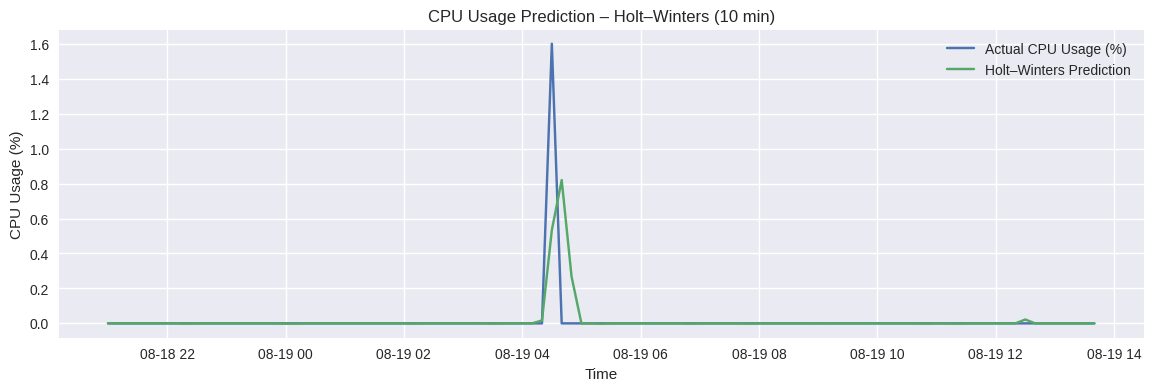

In [380]:
# Visual sanity check

plt.figure(figsize=(14,4))

plt.plot(
    test_cpu_10.index,
    test_cpu_10.values,
    label="Actual CPU Usage (%)"
)

plt.plot(
    test_cpu_10.index,
    cpu_10_hw_preds,
    label="Holt–Winters Prediction"
)

plt.title("CPU Usage Prediction – Holt–Winters (10 min)")
plt.xlabel("Time")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.show()


In [381]:
# CPU 1-hour Holt–Winters

train_cpu_1h, test_cpu_1h = split_train_test(cpu_1h_chunks[0])

cpu_1h_hw_preds = rolling_forecast_hw(
    train_cpu_1h,
    test_cpu_1h,
    seasonal_periods=24
)

cpu_1h_hw_smape = smape(
    test_cpu_1h.values,
    cpu_1h_hw_preds
)

cpu_1h_hw_smape

np.float64(188.4220538563802)

In [382]:
# Memory 10-min Holt–Winters

train_mem_10, test_mem_10 = split_train_test(mem_10min_chunks[0])

mem_10_hw_preds = rolling_forecast_hw(
    train_mem_10,
    test_mem_10,
    seasonal_periods=144
)

mem_10_hw_smape = smape(
    test_mem_10.values,
    mem_10_hw_preds
)

mem_10_hw_smape

np.float64(56.32550685004478)

In [383]:
# Memory 1-hour Holt–Winters

train_mem_1h, test_mem_1h = split_train_test(mem_1h_chunks[0])

mem_1h_hw_preds = rolling_forecast_hw(
    train_mem_1h,
    test_mem_1h,
    seasonal_periods=24
)

mem_1h_hw_smape = smape(
    test_mem_1h.values,
    mem_1h_hw_preds
)

mem_1h_hw_smape

np.float64(21.203902903010533)

In [384]:
hw_results = pd.DataFrame({
    "Signal": [
        "CPU – 10 min",
        "CPU – 1 hour",
        "Memory – 10 min",
        "Memory – 1 hour"
    ],
    "SMAPE (%)": [
        cpu_10_hw_smape,
        cpu_1h_hw_smape,
        mem_10_hw_smape,
        mem_1h_hw_smape
    ]
})

hw_results

,Signal,SMAPE (%)
0,CPU – 10 min,199.010055
1,CPU – 1 hour,188.422054
2,Memory – 10 min,56.325507
3,Memory – 1 hour,21.203903


In [385]:
def scale_series(train, test):
    """
    Scales train and test series using Min-Max normalization
    (Fit on train only to avoid data leakage)
    """
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
    test_scaled  = scaler.transform(test.values.reshape(-1, 1))
    return train_scaled, test_scaled, scaler


In [386]:
def create_sequences(data, window_size):
    """
    Converts a time series into supervised learning format
    X → past window_size values
    y → next value
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)


In [387]:
WINDOW_SIZE = 40   # number of past timesteps used for prediction

In [388]:
def build_lstm(input_shape):
    """
    Standard LSTM model for time series forecasting
    """
    model = Sequential([
        LSTM(24, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="mse"
    )
    return model


In [389]:
def build_bilstm(input_shape):
    """
    Bidirectional LSTM:
    - Learns patterns in forward & backward directions
    - Better at capturing complex temporal dependencies
    """
    model = Sequential([
        Bidirectional(LSTM(32), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="mse"
    )
    return model


In [390]:
def rolling_forecast_lstm(train, test, model_builder):
    """
    Performs walk-forward prediction:
    - Train model once on training data
    - Predict one step ahead
    - Append actual test value to history
    """
    # Scale data
    train_scaled, test_scaled, scaler = scale_series(train, test)

    # Create supervised sequences
    X_train, y_train = create_sequences(train_scaled, WINDOW_SIZE)

    # Build and train model
    model = model_builder((WINDOW_SIZE, 1))
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    # Rolling prediction
    history = list(train_scaled.flatten())
    predictions = []

    for i in range(len(test_scaled)):
        x_input = np.array(history[-WINDOW_SIZE:]).reshape(1, WINDOW_SIZE, 1)
        yhat = model.predict(x_input, verbose=0)[0][0]
        predictions.append(yhat)
        history.append(test_scaled[i][0])  # use actual value

    # Inverse scaling
    predictions = scaler.inverse_transform(
        np.array(predictions).reshape(-1, 1)
    )

    return predictions.flatten()


In [391]:
# CPU 10-min Bi-LSTM Prediction

cpu_10_bilstm_preds = rolling_forecast_lstm(
    train_cpu_10,
    test_cpu_10,
    build_bilstm
)

cpu_10_bilstm_smape = smape(
    test_cpu_10.values,
    cpu_10_bilstm_preds
)

cpu_10_bilstm_smape


np.float64(199.96384221370386)

In [392]:
# CPU 1-hour Bi-LSTM Prediction

# Train / Test split
train_cpu_1h, test_cpu_1h = split_train_test(cpu_1h_chunks[0])

# Rolling forecast using Bi-LSTM
cpu_1h_bilstm_preds = rolling_forecast_lstm(
    train_cpu_1h,
    test_cpu_1h,
    build_bilstm
)

# SMAPE evaluation
cpu_1h_bilstm_smape = smape(
    test_cpu_1h.values,
    cpu_1h_bilstm_preds
)

cpu_1h_bilstm_smape


np.float64(193.2747775850922)

In [393]:

# Train / Test split
train_mem_10, test_mem_10 = split_train_test(mem_10min_chunks[0])

# Rolling forecast using Bi-LSTM
mem_10_bilstm_preds = rolling_forecast_lstm(
    train_mem_10,
    test_mem_10,
    build_bilstm
)

# SMAPE evaluation
mem_10_bilstm_smape = smape(
    test_mem_10.values,
    mem_10_bilstm_preds
)

mem_10_bilstm_smape


np.float64(49.36546372836341)

In [394]:
# Memory 1-hour Bi-LSTM Prediction

# Train / Test split
train_mem_1h, test_mem_1h = split_train_test(mem_1h_chunks[0])

# Rolling forecast using Bi-LSTM
mem_1h_bilstm_preds = rolling_forecast_lstm(
    train_mem_1h,
    test_mem_1h,
    build_bilstm
)

# SMAPE evaluation
mem_1h_bilstm_smape = smape(
    test_mem_1h.values,
    mem_1h_bilstm_preds
)

mem_1h_bilstm_smape


np.float64(33.39732613666192)

In [395]:
def plot_predictions(time_index, actual, predicted, title):
    """
    Plots actual vs predicted time series

    Parameters:
    - time_index : pandas DatetimeIndex
    - actual     : ground truth values
    - predicted  : model predictions
    - title      : plot title
    """
    plt.figure(figsize=(14, 4))
    plt.plot(time_index, actual, label="Actual", linewidth=2)
    plt.plot(time_index, predicted, label="Bi-LSTM", linestyle="--")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Workload Value")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


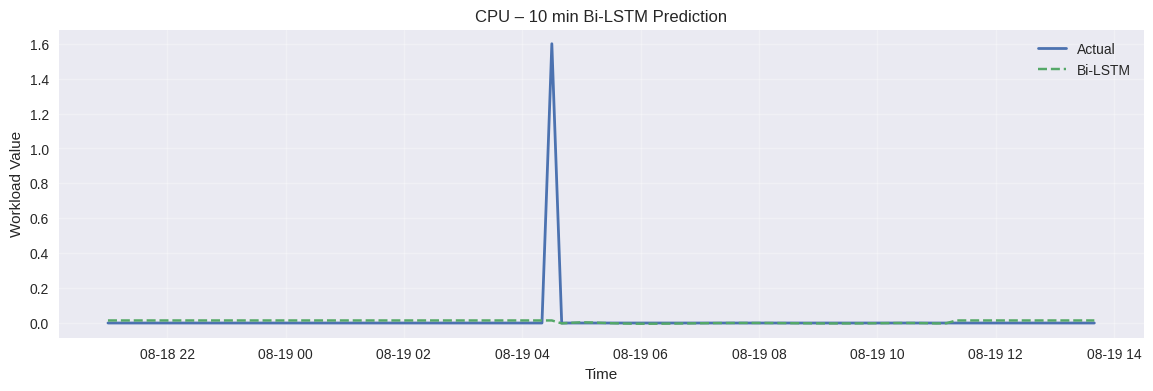

In [396]:
plot_predictions(
    test_cpu_10.index,
    test_cpu_10.values,
    cpu_10_bilstm_preds,
    "CPU – 10 min Bi-LSTM Prediction"
)


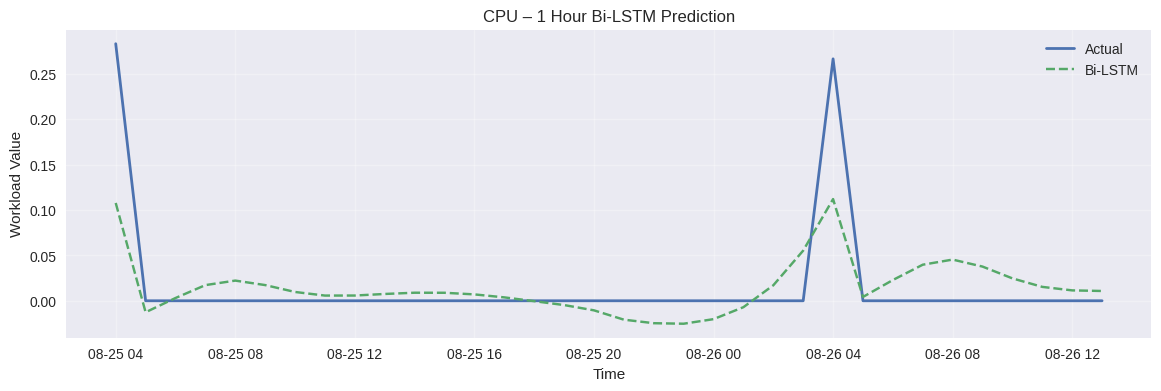

In [397]:
plot_predictions(
    test_cpu_1h.index,
    test_cpu_1h.values,
    cpu_1h_bilstm_preds,
    "CPU – 1 Hour Bi-LSTM Prediction"
)


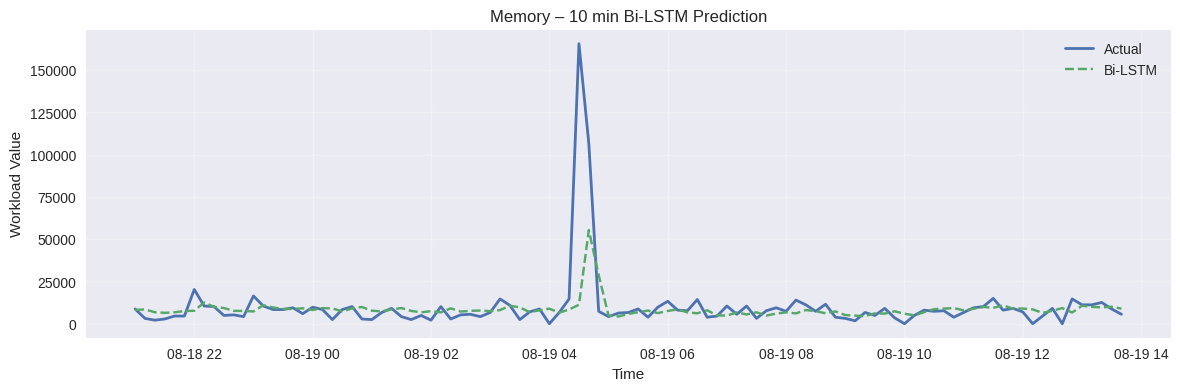

In [398]:
plot_predictions(
    test_mem_10.index,
    test_mem_10.values,
    mem_10_bilstm_preds,
    "Memory – 10 min Bi-LSTM Prediction"
)


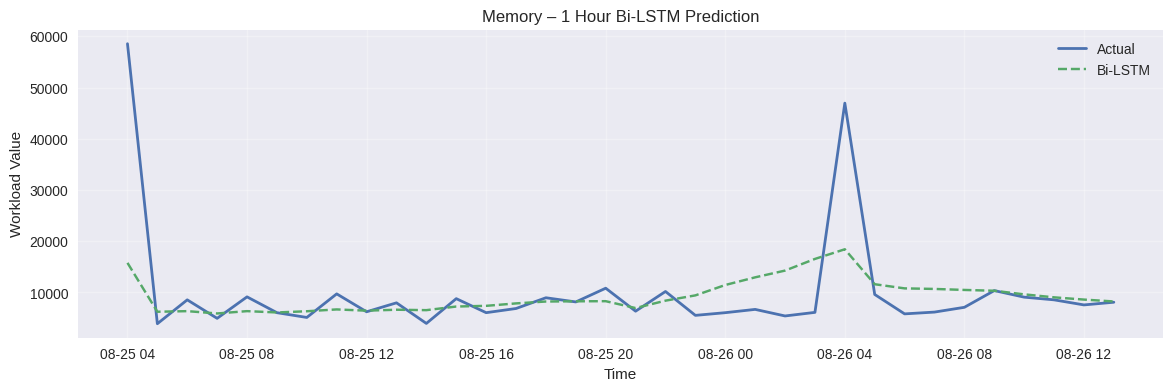

In [399]:
plot_predictions(
    test_mem_1h.index,
    test_mem_1h.values,
    mem_1h_bilstm_preds,
    "Memory – 1 Hour Bi-LSTM Prediction"
)


In [400]:
class OSELM:
    def __init__(self, n_input, n_hidden, activation="sigmoid"):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.activation = activation

        # Random hidden layer parameters
        self.W = np.random.randn(n_input, n_hidden)
        self.b = np.random.randn(n_hidden)

        self.beta = None
        self.P = None

    def _activation(self, X):
        if self.activation == "sigmoid":
            return 1 / (1 + np.exp(-(X @ self.W + self.b)))
        elif self.activation == "tanh":
            return np.tanh(X @ self.W + self.b)
        else:
            raise ValueError("Unsupported activation")

    #  INITIALIZATION (THIS WAS MISSING)
    def initialize(self, X_init, y_init):
        H = self._activation(X_init)
        self.P = np.linalg.inv(
            H.T @ H + np.eye(self.n_hidden) * 1e-6
        )
        self.beta = self.P @ H.T @ y_init

    #  ONLINE UPDATE
    def update(self, X_new, y_new):
        H = self._activation(X_new)
        PH = self.P @ H.T

        self.P = self.P - PH @ np.linalg.inv(
            np.eye(H.shape[0]) + H @ PH
        ) @ H @ self.P

        self.beta = self.beta + self.P @ H.T @ (y_new - H @ self.beta)

    #  PREDICTION
    def predict(self, X):
        H = self._activation(X)
        return H @ self.beta


In [401]:
def prepare_oselm_data(series, window_size):
    """
    Converts time series into OS-ELM supervised format
    """
    X, y = [], []
    values = series.values

    for i in range(len(values) - window_size):
        X.append(values[i:i + window_size])
        y.append(values[i + window_size])

    return np.array(X), np.array(y)


In [402]:
def rolling_forecast_oselm(
    train,
    test,
    window_size,
    n_hidden=35,
    init_size=100
):
    """
    OS-ELM rolling forecast:
    - Initialize with small batch
    - Predict one step ahead
    - Update model with true value (online)
    """

    # Prepare training and rolling test data
    X_train, y_train = prepare_oselm_data(train, window_size)

    X_test, y_test = prepare_oselm_data(
        pd.concat([train.iloc[-window_size:], test]),
        window_size
    )

    # Initialize OS-ELM
    model = OSELM(
        n_input=window_size,
        n_hidden=n_hidden,
        activation="sigmoid"
    )

    model.initialize(
        X_train[:init_size],
        y_train[:init_size].reshape(-1, 1)
    )

    predictions = []

    # Online prediction + update loop
    for i in range(len(X_test)):
        y_pred = model.predict(X_test[i:i + 1])[0, 0]
        predictions.append(y_pred)

        # Update with true observed value
        model.update(
            X_test[i:i + 1],
            np.array([[y_test[i]]])
        )

    return np.array(predictions)


In [403]:
cpu_10_oselm_preds = rolling_forecast_oselm(
    train_cpu_10,
    test_cpu_10,
    window_size=WINDOW_SIZE,
    n_hidden=35
)


In [404]:
oselm_y_true = pd.concat([
    train_cpu_10.iloc[-WINDOW_SIZE:],
    test_cpu_10
]).values[WINDOW_SIZE:]

oselm_time_index = pd.concat([
    train_cpu_10.iloc[-WINDOW_SIZE:],
    test_cpu_10
]).index[WINDOW_SIZE:]


In [405]:
print("OS-ELM y_true length :", len(oselm_y_true))
print("OS-ELM preds length  :", len(cpu_10_oselm_preds))
print("OS-ELM time length   :", len(oselm_time_index))


OS-ELM y_true length : 101
OS-ELM preds length  : 101
OS-ELM time length   : 101


In [406]:
cpu_10_oselm_smape = smape(
    oselm_y_true,
    cpu_10_oselm_preds
)

cpu_10_oselm_smape


np.float64(199.964806257792)

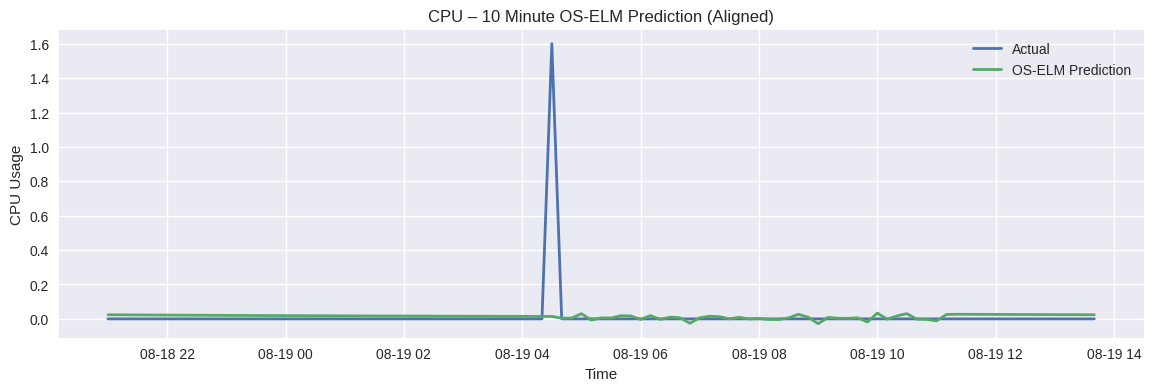

In [407]:
plt.figure(figsize=(14, 4))

plt.plot(
    oselm_time_index,
    oselm_y_true,
    label="Actual",
    linewidth=2
)

plt.plot(
    oselm_time_index,
    cpu_10_oselm_preds,
    label="OS-ELM Prediction",
    linewidth=2
)

plt.title("CPU – 10 Minute OS-ELM Prediction (Aligned)")
plt.xlabel("Time")
plt.ylabel("CPU Usage")
plt.legend()
plt.grid(True)
plt.show()


In [408]:
 # CPU 1-hour OS-ELM Prediction

cpu_1h_oselm_preds = rolling_forecast_oselm(
    train_cpu_1h,
    test_cpu_1h,
    window_size=WINDOW_SIZE,
    n_hidden=35
)

# Align ground truth
oselm_cpu_1h_y_true = pd.concat([
    train_cpu_1h.iloc[-WINDOW_SIZE:],
    test_cpu_1h
]).values[WINDOW_SIZE:]

oselm_cpu_1h_time = pd.concat([
    train_cpu_1h.iloc[-WINDOW_SIZE:],
    test_cpu_1h
]).index[WINDOW_SIZE:]

# Sanity check
print(len(oselm_cpu_1h_y_true), len(cpu_1h_oselm_preds))

# SMAPE
cpu_1h_oselm_smape = smape(
    oselm_cpu_1h_y_true,
    cpu_1h_oselm_preds
)

cpu_1h_oselm_smape


34 34


np.float64(188.55011801920577)

In [409]:
 # Memory 10-min OS-ELM Prediction

mem_10_oselm_preds = rolling_forecast_oselm(
    train_mem_10,
    test_mem_10,
    window_size=WINDOW_SIZE,
    n_hidden=35
)

# Align ground truth
oselm_mem_10_y_true = pd.concat([
    train_mem_10.iloc[-WINDOW_SIZE:],
    test_mem_10
]).values[WINDOW_SIZE:]

oselm_mem_10_time = pd.concat([
    train_mem_10.iloc[-WINDOW_SIZE:],
    test_mem_10
]).index[WINDOW_SIZE:]

# Sanity check
print(len(oselm_mem_10_y_true), len(mem_10_oselm_preds))

# SMAPE
mem_10_oselm_smape = smape(
    oselm_mem_10_y_true,
    mem_10_oselm_preds
)

mem_10_oselm_smape


101 101


np.float64(99.74995599620081)

In [410]:
 # Memory 1-hour OS-ELM Prediction

mem_1h_oselm_preds = rolling_forecast_oselm(
    train_mem_1h,
    test_mem_1h,
    window_size=WINDOW_SIZE,
    n_hidden=35
)

# Align ground truth
oselm_mem_1h_y_true = pd.concat([
    train_mem_1h.iloc[-WINDOW_SIZE:],
    test_mem_1h
]).values[WINDOW_SIZE:]

oselm_mem_1h_time = pd.concat([
    train_mem_1h.iloc[-WINDOW_SIZE:],
    test_mem_1h
]).index[WINDOW_SIZE:]

# Sanity check
print(len(oselm_mem_1h_y_true), len(mem_1h_oselm_preds))

# SMAPE
mem_1h_oselm_smape = smape(
    oselm_mem_1h_y_true,
    mem_1h_oselm_preds
)

mem_1h_oselm_smape


34 34


np.float64(70.68344538138746)

In [411]:
def plot_oselm(time_index, y_true, y_pred, title, ylabel):
    plt.figure(figsize=(14, 4))
    plt.plot(time_index, y_true, label="Actual", linewidth=2)
    plt.plot(time_index, y_pred, label="OS-ELM", linewidth=2)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()


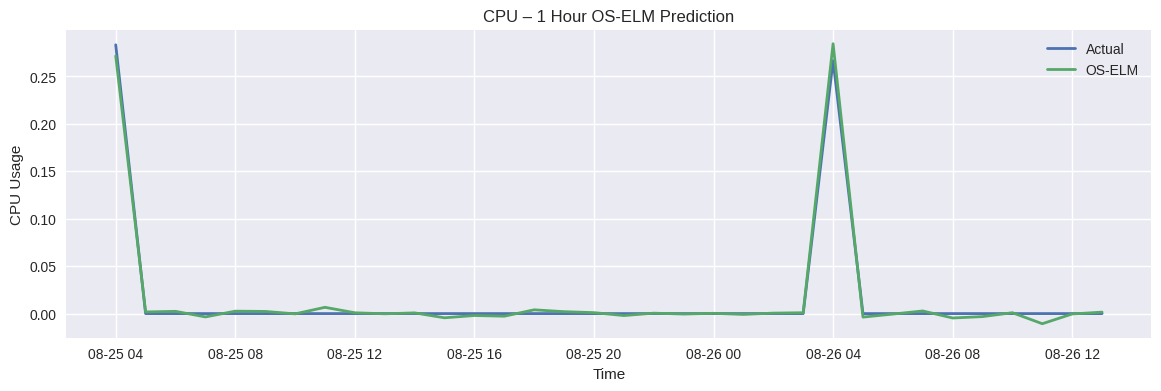

In [412]:
plot_oselm(
    oselm_cpu_1h_time,
    oselm_cpu_1h_y_true,
    cpu_1h_oselm_preds,
    "CPU – 1 Hour OS-ELM Prediction",
    "CPU Usage"
)


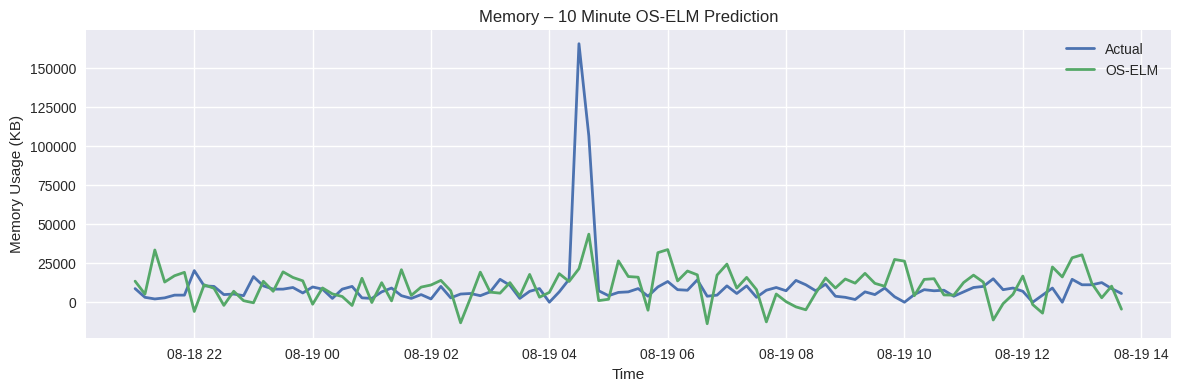

In [413]:
plot_oselm(
    oselm_mem_10_time,
    oselm_mem_10_y_true,
    mem_10_oselm_preds,
    "Memory – 10 Minute OS-ELM Prediction",
    "Memory Usage (KB)"
)


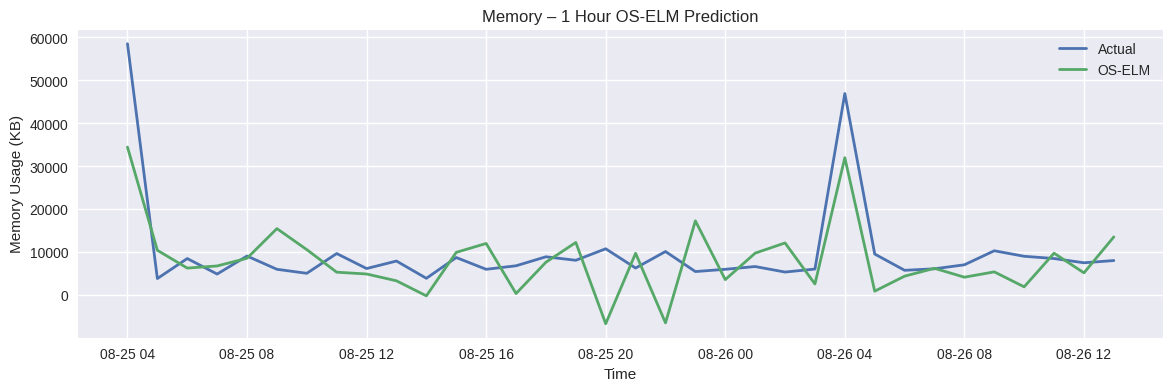

In [414]:
plot_oselm(
    oselm_mem_1h_time,
    oselm_mem_1h_y_true,
    mem_1h_oselm_preds,
    "Memory – 1 Hour OS-ELM Prediction",
    "Memory Usage (KB)"
)


In [415]:
# Ground truth
y_true = test_cpu_10.values
n_test = len(y_true)

# HW & Bi-LSTM already predict ONLY test horizon
hw_preds = cpu_10_hw_preds
bilstm_preds = cpu_10_bilstm_preds

# OS-ELM predicts (train_tail + test) → keep ONLY test
oselm_preds = cpu_10_oselm_preds[-n_test:]

# Sanity check (MUST match)
print("HW preds     :", len(hw_preds))
print("Bi-LSTM preds:", len(bilstm_preds))
print("OS-ELM preds :", len(oselm_preds))
print("y_true       :", len(y_true))


HW preds     : 101
Bi-LSTM preds: 101
OS-ELM preds : 101
y_true       : 101


In [416]:
mean_ensemble = (hw_preds + bilstm_preds + oselm_preds) / 3
mean_smape = smape(y_true, mean_ensemble)
mean_smape


np.float64(199.58469896653767)

In [417]:
def adaptive_weighted_ensemble(pred_matrix, y_true, alpha=0.9):
    """
    pred_matrix: shape (T, 3) → [HW, Bi-LSTM, OS-ELM]
    """
    T, M = pred_matrix.shape
    weights = np.ones(M) / M
    ensemble_preds = []

    for t in range(T):
        # Prediction
        y_hat = np.dot(weights, pred_matrix[t])
        ensemble_preds.append(y_hat)

        # Error-based weight update
        errors = np.abs(pred_matrix[t] - y_true[t]) + 1e-6
        new_weights = 1 / errors
        new_weights = new_weights / new_weights.sum()

        # Smooth update
        weights = alpha * weights + (1 - alpha) * new_weights

    return np.array(ensemble_preds)


In [418]:
pred_matrix = np.column_stack([
    hw_preds,
    bilstm_preds,
    oselm_preds
])

adaptive_preds = adaptive_weighted_ensemble(
    pred_matrix,
    y_true
)

adaptive_smape = smape(y_true, adaptive_preds)
adaptive_smape


np.float64(199.08223278974015)

In [419]:
metrics_df = pd.DataFrame({
    "Model": [
        "Holt-Winters",
        "Bi-LSTM",
        "OS-ELM",
        "Mean Ensemble",
        "Adaptive Ensemble"
    ],
    "SMAPE (%)": [
        smape(y_true, hw_preds),
        smape(y_true, bilstm_preds),
        smape(y_true, oselm_preds),
        mean_smape,
        adaptive_smape
    ],
    "MSE": [
        mse(y_true, hw_preds),
        mse(y_true, bilstm_preds),
        mse(y_true, oselm_preds),
        mse(y_true, mean_ensemble),
        mse(y_true, adaptive_preds)
    ],
    "RMSE": [
        rmse(y_true, hw_preds),
        rmse(y_true, bilstm_preds),
        rmse(y_true, oselm_preds),
        rmse(y_true, mean_ensemble),
        rmse(y_true, adaptive_preds)
    ]
})

metrics_df


,Model,SMAPE (%),MSE,RMSE
0,Holt-Winters,199.010055,0.018639,0.136523
1,Bi-LSTM,199.963842,0.025012,0.158153
2,OS-ELM,199.964806,0.025232,0.158846
3,Mean Ensemble,199.584699,0.020675,0.143788
4,Adaptive Ensemble,199.082233,0.017666,0.132914


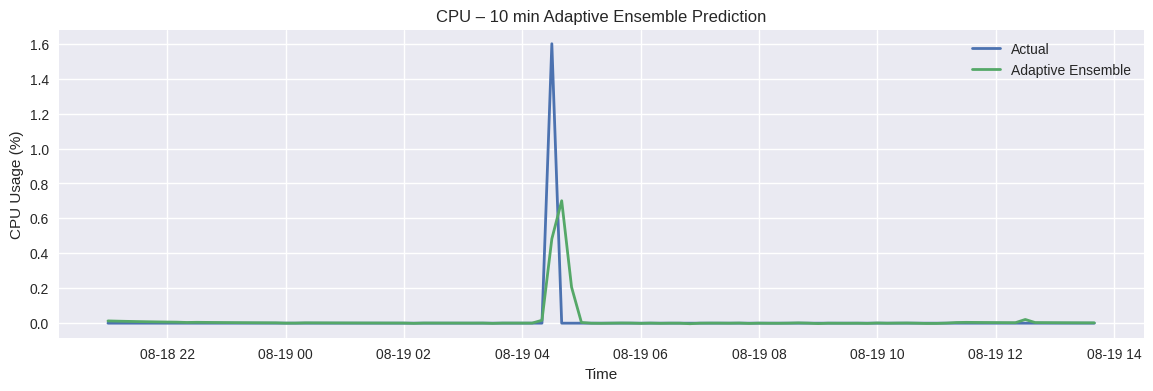

In [420]:
plt.figure(figsize=(14,4))

plt.plot(test_cpu_10.index, y_true, label="Actual", linewidth=2)
plt.plot(test_cpu_10.index, adaptive_preds, label="Adaptive Ensemble", linewidth=2)

plt.title("CPU – 10 min Adaptive Ensemble Prediction")
plt.xlabel("Time")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.grid(True)
plt.show()


In [421]:
y_true_cpu_1h = test_cpu_1h.values
n_test_1h = len(y_true_cpu_1h)


In [422]:
hw_cpu_1h   = cpu_1h_hw_preds
bilstm_cpu_1h = cpu_1h_bilstm_preds
oselm_cpu_1h  = cpu_1h_oselm_preds[-n_test_1h:]

print(
    len(hw_cpu_1h),
    len(bilstm_cpu_1h),
    len(oselm_cpu_1h),
    len(y_true_cpu_1h)
)


34 34 34 34


In [423]:
cpu_1h_mean_ensemble = (
    hw_cpu_1h + bilstm_cpu_1h + oselm_cpu_1h
) / 3

cpu_1h_mean_smape = smape(y_true_cpu_1h, cpu_1h_mean_ensemble)


In [424]:
pred_matrix_cpu_1h = np.column_stack([
    hw_cpu_1h,
    bilstm_cpu_1h,
    oselm_cpu_1h
])

cpu_1h_adaptive_preds = adaptive_weighted_ensemble(
    pred_matrix_cpu_1h,
    y_true_cpu_1h
)

cpu_1h_adaptive_smape = smape(
    y_true_cpu_1h,
    cpu_1h_adaptive_preds
)


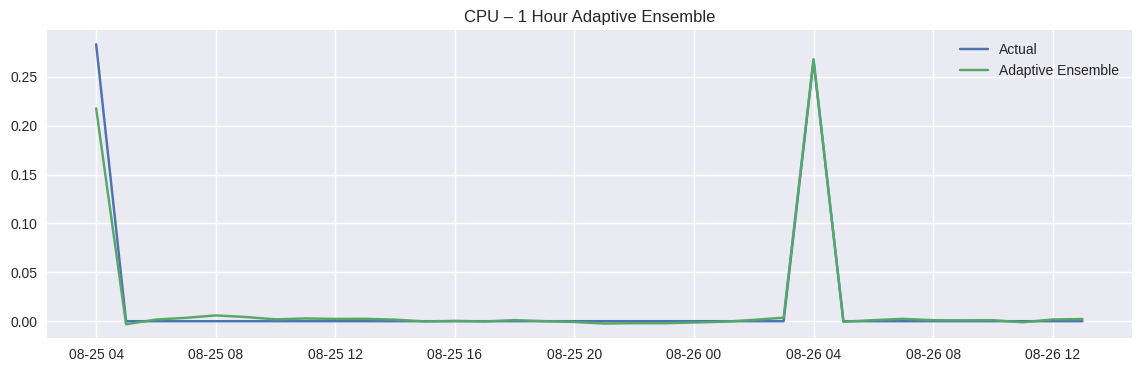

In [425]:
plt.figure(figsize=(14,4))
plt.plot(test_cpu_1h.index, y_true_cpu_1h, label="Actual")
plt.plot(test_cpu_1h.index, cpu_1h_adaptive_preds, label="Adaptive Ensemble")
plt.title("CPU – 1 Hour Adaptive Ensemble")
plt.legend()
plt.grid(True)
plt.show()


In [426]:
y_true_mem_10 = test_mem_10.values
n_test_mem_10 = len(y_true_mem_10)


In [427]:
hw_mem_10   = mem_10_hw_preds
bilstm_mem_10 = mem_10_bilstm_preds
oselm_mem_10  = mem_10_oselm_preds[-n_test_mem_10:]

print(
    len(hw_mem_10),
    len(bilstm_mem_10),
    len(oselm_mem_10),
    len(y_true_mem_10)
)


101 101 101 101


In [428]:
mem_10_mean_ensemble = (
    hw_mem_10 + bilstm_mem_10 + oselm_mem_10
) / 3

mem_10_mean_smape = smape(y_true_mem_10, mem_10_mean_ensemble)


In [429]:
pred_matrix_mem_10 = np.column_stack([
    hw_mem_10,
    bilstm_mem_10,
    oselm_mem_10
])

mem_10_adaptive_preds = adaptive_weighted_ensemble(
    pred_matrix_mem_10,
    y_true_mem_10
)

mem_10_adaptive_smape = smape(
    y_true_mem_10,
    mem_10_adaptive_preds
)


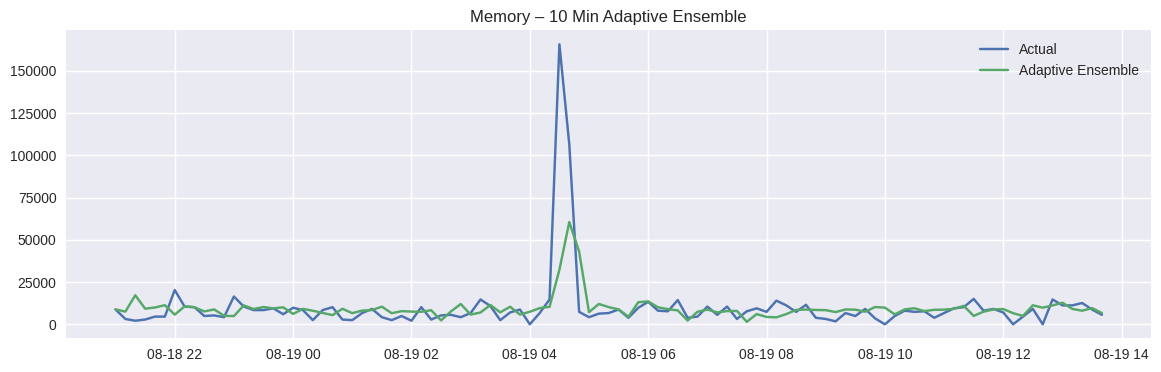

In [430]:
plt.figure(figsize=(14,4))
plt.plot(test_mem_10.index, y_true_mem_10, label="Actual")
plt.plot(test_mem_10.index, mem_10_adaptive_preds, label="Adaptive Ensemble")
plt.title("Memory – 10 Min Adaptive Ensemble")
plt.legend()
plt.grid(True)
plt.show()


In [431]:
y_true_mem_1h = test_mem_1h.values
n_test_mem_1h = len(y_true_mem_1h)


In [432]:
hw_mem_1h   = mem_1h_hw_preds
bilstm_mem_1h = mem_1h_bilstm_preds
oselm_mem_1h  = mem_1h_oselm_preds[-n_test_mem_1h:]

print(
    len(hw_mem_1h),
    len(bilstm_mem_1h),
    len(oselm_mem_1h),
    len(y_true_mem_1h)
)


34 34 34 34


In [433]:
mem_1h_mean_ensemble = (
    hw_mem_1h + bilstm_mem_1h + oselm_mem_1h
) / 3

mem_1h_mean_smape = smape(y_true_mem_1h, mem_1h_mean_ensemble)


In [434]:
pred_matrix_mem_1h = np.column_stack([
    hw_mem_1h,
    bilstm_mem_1h,
    oselm_mem_1h
])

mem_1h_adaptive_preds = adaptive_weighted_ensemble(
    pred_matrix_mem_1h,
    y_true_mem_1h
)

mem_1h_adaptive_smape = smape(
    y_true_mem_1h,
    mem_1h_adaptive_preds
)


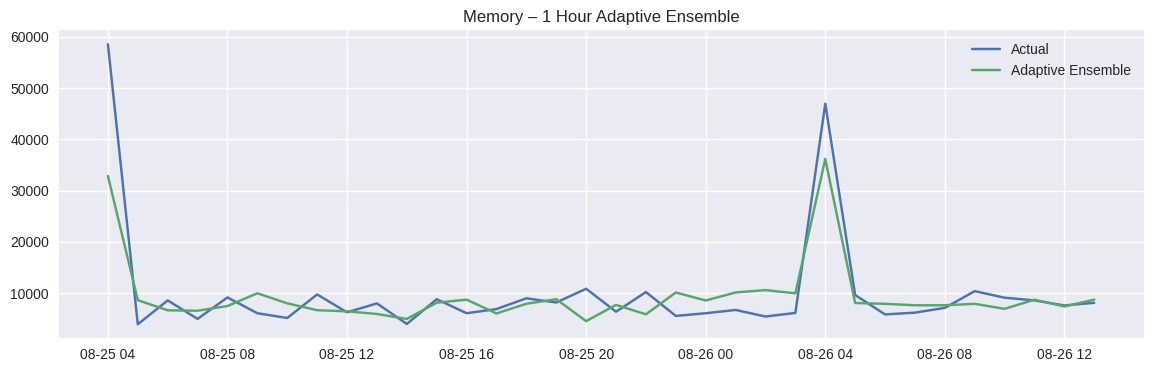

In [435]:
plt.figure(figsize=(14,4))
plt.plot(test_mem_1h.index, y_true_mem_1h, label="Actual")
plt.plot(test_mem_1h.index, mem_1h_adaptive_preds, label="Adaptive Ensemble")
plt.title("Memory – 1 Hour Adaptive Ensemble")
plt.legend()
plt.grid(True)
plt.show()


In [436]:
final_metrics = pd.DataFrame({
    "Scenario": [
        "CPU 10-min",
        "CPU 1-hour",
        "Memory 10-min",
        "Memory 1-hour"
    ],
    "Adaptive SMAPE (%)": [
        adaptive_smape,
        cpu_1h_adaptive_smape,
        mem_10_adaptive_smape,
        mem_1h_adaptive_smape
    ]
})

final_metrics


,Scenario,Adaptive SMAPE (%)
0,CPU 10-min,199.082233
1,CPU 1-hour,189.022089
2,Memory 10-min,54.326523
3,Memory 1-hour,30.457675


In [437]:

#  9.1: PERFORMANCE METRIC FUNCTIONS


from sklearn.metrics import mean_squared_error

def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_regression(y_true, y_pred):
    return {
        "SMAPE (%)": smape(y_true, y_pred),
        "MSE": mse(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred)
    }


In [438]:

#  9.2: CPU – 10 MIN METRICS TABLE


# Ground truth
y_true_cpu_10 = test_cpu_10.values
n_test_10 = len(y_true_cpu_10)

# Align predictions
hw_cpu_10      = cpu_10_hw_preds
bilstm_cpu_10  = cpu_10_bilstm_preds
oselm_cpu_10   = cpu_10_oselm_preds[-n_test_10:]
adaptive_cpu_10 = adaptive_preds

# Sanity check
print(
    len(y_true_cpu_10),
    len(hw_cpu_10),
    len(bilstm_cpu_10),
    len(oselm_cpu_10),
    len(adaptive_cpu_10)
)

# Build results table
cpu_10_results = pd.DataFrame([
    {"Model": "Holt-Winters", **evaluate_regression(y_true_cpu_10, hw_cpu_10)},
    {"Model": "Bi-LSTM",      **evaluate_regression(y_true_cpu_10, bilstm_cpu_10)},
    {"Model": "OS-ELM",       **evaluate_regression(y_true_cpu_10, oselm_cpu_10)},
    {"Model": "Adaptive Ensemble", **evaluate_regression(y_true_cpu_10, adaptive_cpu_10)}
])

cpu_10_results


101 101 101 101 101


,Model,SMAPE (%),MSE,RMSE
0,Holt-Winters,199.010055,0.018639,0.136523
1,Bi-LSTM,199.963842,0.025012,0.158153
2,OS-ELM,199.964806,0.025232,0.158846
3,Adaptive Ensemble,199.082233,0.017666,0.132914


In [439]:

#  9.3: CPU – 1 HOUR METRICS TABLE


# Ground truth
y_true_cpu_1h = test_cpu_1h.values
n_test_1h = len(y_true_cpu_1h)

# Align predictions
hw_cpu_1h       = cpu_1h_hw_preds
bilstm_cpu_1h   = cpu_1h_bilstm_preds
oselm_cpu_1h    = cpu_1h_oselm_preds[-n_test_1h:]
adaptive_cpu_1h = cpu_1h_adaptive_preds

# Sanity check (lengths must match)
print(
    len(y_true_cpu_1h),
    len(hw_cpu_1h),
    len(bilstm_cpu_1h),
    len(oselm_cpu_1h),
    len(adaptive_cpu_1h)
)

# Build results table
cpu_1h_results = pd.DataFrame([
    {"Model": "Holt-Winters", **evaluate_regression(y_true_cpu_1h, hw_cpu_1h)},
    {"Model": "Bi-LSTM",      **evaluate_regression(y_true_cpu_1h, bilstm_cpu_1h)},
    {"Model": "OS-ELM",       **evaluate_regression(y_true_cpu_1h, oselm_cpu_1h)},
    {"Model": "Adaptive Ensemble", **evaluate_regression(y_true_cpu_1h, adaptive_cpu_1h)}
])

cpu_1h_results


34 34 34 34 34


,Model,SMAPE (%),MSE,RMSE
0,Holt-Winters,188.422054,0.000005,0.002249
1,Bi-LSTM,193.274778,0.002021,0.044954
2,OS-ELM,188.550118,0.000022,0.004738
3,Adaptive Ensemble,189.022089,0.000131,0.011459


In [440]:

#  9.4: MEMORY – 10 MIN METRICS TABLE


# Ground truth
y_true_mem_10 = test_mem_10.values
n_test_mem_10 = len(y_true_mem_10)

# Align predictions
hw_mem_10       = mem_10_hw_preds
bilstm_mem_10   = mem_10_bilstm_preds
oselm_mem_10    = mem_10_oselm_preds[-n_test_mem_10:]
adaptive_mem_10 = mem_10_adaptive_preds

# Sanity check (all lengths must match)
print(
    len(y_true_mem_10),
    len(hw_mem_10),
    len(bilstm_mem_10),
    len(oselm_mem_10),
    len(adaptive_mem_10)
)

# Build results table
mem_10_results = pd.DataFrame([
    {"Model": "Holt-Winters", **evaluate_regression(y_true_mem_10, hw_mem_10)},
    {"Model": "Bi-LSTM",      **evaluate_regression(y_true_mem_10, bilstm_mem_10)},
    {"Model": "OS-ELM",       **evaluate_regression(y_true_mem_10, oselm_mem_10)},
    {"Model": "Adaptive Ensemble", **evaluate_regression(y_true_mem_10, adaptive_mem_10)}
])

mem_10_results


101 101 101 101 101


,Model,SMAPE (%),MSE,RMSE
0,Holt-Winters,56.325507,1.807826e+08,13445.542704
1,Bi-LSTM,49.365464,2.828603e+08,16818.451253
2,OS-ELM,99.749956,3.684587e+08,19195.278892
3,Adaptive Ensemble,54.326523,2.315672e+08,15217.330898


In [441]:

#  9.5: MEMORY – 1 HOUR METRICS TABLE


# Ground truth
y_true_mem_1h = test_mem_1h.values
n_test_mem_1h = len(y_true_mem_1h)

# Align predictions
hw_mem_1h       = mem_1h_hw_preds
bilstm_mem_1h   = mem_1h_bilstm_preds
oselm_mem_1h    = mem_1h_oselm_preds[-n_test_mem_1h:]
adaptive_mem_1h = mem_1h_adaptive_preds

# Sanity check (lengths MUST match)
print(
    len(y_true_mem_1h),
    len(hw_mem_1h),
    len(bilstm_mem_1h),
    len(oselm_mem_1h),
    len(adaptive_mem_1h)
)

# Build results table
mem_1h_results = pd.DataFrame([
    {"Model": "Holt-Winters", **evaluate_regression(y_true_mem_1h, hw_mem_1h)},
    {"Model": "Bi-LSTM",      **evaluate_regression(y_true_mem_1h, bilstm_mem_1h)},
    {"Model": "OS-ELM",       **evaluate_regression(y_true_mem_1h, oselm_mem_1h)},
    {"Model": "Adaptive Ensemble", **evaluate_regression(y_true_mem_1h, adaptive_mem_1h)}
])

mem_1h_results


34 34 34 34 34


,Model,SMAPE (%),MSE,RMSE
0,Holt-Winters,21.203903,6.673095e+06,2583.233429
1,Bi-LSTM,33.397326,8.908787e+07,9438.637304
2,OS-ELM,70.683445,6.266683e+07,7916.238076
3,Adaptive Ensemble,30.457675,2.990706e+07,5468.734528


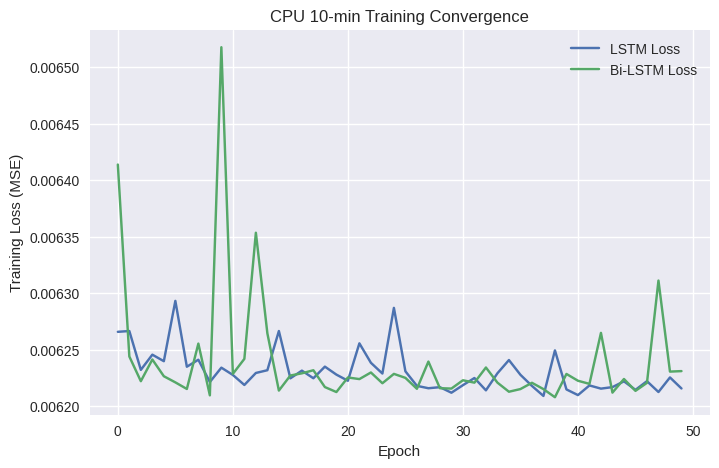

In [442]:

#  10.1: CONVERGENCE — CPU (10 MIN)


plt.figure(figsize=(8,5))

plt.plot(
    history_lstm.history["loss"],
    label="LSTM Loss"
)

plt.plot(
    history_bilstm.history["loss"],
    label="Bi-LSTM Loss"
)

plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("CPU 10-min Training Convergence")
plt.legend()
plt.grid(True)
plt.show()


In [443]:

#  11.1: DEFINE OVERLOAD EVENTS


from sklearn.metrics import f1_score, classification_report

# Overload threshold (paper-friendly choice)
CPU_OVERLOAD_THRESHOLD = 0.8 * y_true_cpu_10.max()

# Ground truth labels
y_true_overload = (y_true_cpu_10 > CPU_OVERLOAD_THRESHOLD).astype(int)


In [444]:

#  11.2: F1-SCORE — CPU 10-MIN


f1_results = {
    "Holt-Winters": f1_score(
        y_true_overload,
        (cpu_10_hw_preds > CPU_OVERLOAD_THRESHOLD).astype(int)
    ),
    "Bi-LSTM": f1_score(
        y_true_overload,
        (cpu_10_bilstm_preds > CPU_OVERLOAD_THRESHOLD).astype(int)
    ),
    "Adaptive Ensemble": f1_score(
        y_true_overload,
        (adaptive_preds > CPU_OVERLOAD_THRESHOLD).astype(int)
    )
}

pd.DataFrame.from_dict(
    f1_results,
    orient="index",
    columns=["F1 Score"]
)


,F1 Score
Holt-Winters,0.0
Bi-LSTM,0.0
Adaptive Ensemble,0.0


In [445]:

#  12.1: DEFINE SLA


SLA_LIMIT = 0.9 * y_true_cpu_10.max()


In [446]:

#  12.2: SLA VIOLATION COUNTS


def count_sla_violations(y_true, y_pred, sla_limit):
    return np.sum((y_true > sla_limit) & (y_pred < sla_limit))

sla_results = {
    "Holt-Winters": count_sla_violations(
        y_true_cpu_10, cpu_10_hw_preds, SLA_LIMIT
    ),
    "Bi-LSTM": count_sla_violations(
        y_true_cpu_10, cpu_10_bilstm_preds, SLA_LIMIT
    ),
    "Adaptive Ensemble": count_sla_violations(
        y_true_cpu_10, adaptive_preds, SLA_LIMIT
    )
}

pd.DataFrame.from_dict(
    sla_results,
    orient="index",
    columns=["SLA Violations"]
)


,SLA Violations
Holt-Winters,1
Bi-LSTM,1
Adaptive Ensemble,1


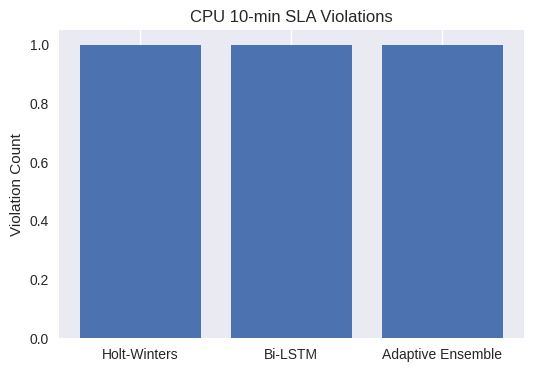

In [447]:

#  12.3: SLA VIOLATION BAR PLOT


plt.figure(figsize=(6,4))
plt.bar(sla_results.keys(), sla_results.values())
plt.ylabel("Violation Count")
plt.title("CPU 10-min SLA Violations")
plt.grid(axis="y")
plt.show()
